# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [102]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy import stats
from scipy.stats import ttest_ind


## Cargar datos

In [103]:
# Cargar los datos en DataFrames
calls_df = pd.read_csv("/datasets/megaline_calls.csv")
internet_df = pd.read_csv("/datasets/megaline_internet.csv")
messages_df = pd.read_csv("/datasets/megaline_messages.csv")
plans_df = pd.read_csv("/datasets/megaline_plans.csv")
users_df = pd.read_csv("/datasets/megaline_users.csv")

## Preparar los datos

## Tarifas

In [104]:
# Imprimir la información general/resumida sobre el DataFrame de las tarifas

plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [105]:
# Imprimir una muestra detallada de las columnas de precios
price_columns = ['usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute']
display(plans_df[price_columns].head())

,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,20,10,0.03,0.03
1,70,7,0.01,0.01


Analizando el DataFrame de tarifas (plans_df), observamos que no hay valores nulos en ninguna columna, y los tipos de datos parecen ser apropiados. La muestra de datos revela información detallada sobre cada tarifa, incluidos los minutos, mensajes y datos incluidos, así como los costos asociados. Se imprimimieron los tipos de datos en las columnas de precios (usd_monthly_pay, usd_per_gb, usd_per_message, usd_per_minute), y no se encontró necesidad de modificarlos ya que no se identificaron problemas significativos en la muestra.

## Corregir datos

In [106]:
# Cambiar los valores de la columna a GB convirtiendo a enteros.
plans_df['mb_per_month_included'] = (plans_df['mb_per_month_included']/1024).astype('int')

# Cambiar el nombre de la columna "mb_per_month_included" a "gb_per_month_included"
plans_df = plans_df.rename(columns={'mb_per_month_included':'gb_per_month_included'})

## Enriquecer los datos

## Usuarios/as

In [107]:
# Imprimir la información general/resumida sobre el DataFrame de usuarios

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [108]:
# Imprimir una muestra de datos para usuarios
users_df.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
55,1055,Patrick,Mclean,52,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-01-13,surf,NaN
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaN
65,1065,Sherlyn,Noel,26,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-08-03,surf,NaN
241,1241,Lala,Walls,24,"Richmond, VA MSA",2018-08-27,surf,NaN
331,1331,Lashandra,Ramos,54,"Dallas-Fort Worth-Arlington, TX MSA",2018-02-06,surf,NaN


El DataFrame de usuarios consta de 500 registros, cada uno representando a un usuario de Megaline. La información es completa en la mayoría de las columnas, con datos presentes para atributos como user_id, first_name, last_name, age, city, reg_date, y plan. Sin embargo, la columna churn_date muestra que hay 34 usuarios que han dejado de utilizar el servicio en algún momento, ya que contiene fechas de cese de uso. Este hallazgo sugiere que algunos usuarios han optado por cancelar su suscripción, lo cual podría ser relevante al analizar el comportamiento y los ingresos de los clientes.

### Corregir los datos

In [109]:
# Se convieren las columnas 'reg_date' y 'churn_date' a tipos de datos de fecha.
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format = '%Y-%m-%d')
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format = '%Y-%m-%d')

# Definir la función churn_categories
def churn_categories(churn_date):
    if pd.isna(churn_date):
        return 'active'
    return 'inactive'

# Aplicar la función churn_categories para crear la columna churn_categories
users_df['churn_categories'] = users_df['churn_date'].apply(churn_categories)

# Reemplazar los valores NaT en la columna churn_date con una fecha fuera del rango de los datos
users_df['churn_date'] = users_df['churn_date'].fillna(value=pd.to_datetime('2019-01-01'))

# Se busca y elimina cualquier fila duplicada en el dataframe.
users_df = users_df.drop_duplicates()

In [110]:
# Imprimir información del DataFrame después de las transformaciones
print(users_df.info())

# Mostrar las primeras filas del DataFrame
users_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           500 non-null    int64         
 1   first_name        500 non-null    object        
 2   last_name         500 non-null    object        
 3   age               500 non-null    int64         
 4   city              500 non-null    object        
 5   reg_date          500 non-null    datetime64[ns]
 6   plan              500 non-null    object        
 7   churn_date        500 non-null    datetime64[ns]
 8   churn_categories  500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 39.1+ KB
None


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,churn_categories
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,active
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,active
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,active
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,active


### Enriquecer los datos

In [111]:
# Crear una nueva columna 'subscription_duration' que represente la duración de la suscripción de cada usuario en meses.
users_df['subscription_duration'] = (users_df['churn_date'] - users_df['reg_date']).dt.days / 30

# Crear una nueva columna 'is_churned' que indica si un usuario ha cancelado su suscripción
users_df['is_churned'] = ~users_df['churn_date'].isnull()

# Copiar la columna 'plan' a una nueva columna 'plan_name'
users_df['plan_name']=users_df['plan']

# Imprimir información actualizada
users_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                500 non-null    int64         
 1   first_name             500 non-null    object        
 2   last_name              500 non-null    object        
 3   age                    500 non-null    int64         
 4   city                   500 non-null    object        
 5   reg_date               500 non-null    datetime64[ns]
 6   plan                   500 non-null    object        
 7   churn_date             500 non-null    datetime64[ns]
 8   churn_categories       500 non-null    object        
 9   subscription_duration  500 non-null    float64       
 10  is_churned             500 non-null    bool          
 11  plan_name              500 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(1), int64(2), object(6)
m

## Llamadas

In [112]:
# Imprimir la información general/resumida sobre el DataFrame de las llamadas

calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [113]:
# Imprimir una muestra de datos para las llamadas

calls_df.sample(5)

,id,user_id,call_date,duration
124431,1439_299,1439,2018-06-25,6.48
42189,1155_143,1155,2018-10-03,1.25
85370,1313_350,1313,2018-10-20,1.99
52452,1187_645,1187,2018-05-07,0.00
21308,1079_21,1079,2018-08-16,6.53


El DataFrame de llamadas comprende 137,735 registros, cada uno representa una llamada realizada por los usuarios de Megaline. La estructura del DataFrame es robusta, sin valores nulos en ninguna de las columnas. Las columnas clave, como id, user_id, call_date, y duration, contienen tipos de datos adecuados. Es importante destacar que la columna call_date actualmente tiene un tipo de dato de objeto, lo que afectará la manipulación en análisis temporales. Por lo tanto, se hará lo necesrio para convertir esta columna a un tipo de dato de fecha. Además, se observa que la duración de las llamadas se presenta en minutos redondeados, siguiendo las prácticas de redondeo de Megaline, lo que será crucial para el cálculo preciso de los ingresos y la comprensión de los patrones de uso de los usuarios.

### Corregir los datos

In [114]:
# Convertir la columna 'call_date' al tipo de dato de fecha
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')

# Agrupar por 'user_id' y 'month'
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int)

# Filtrado de llamadas perdidas con duración de "0".
miss_calls = calls_df.query('duration == 0')
calls_df = calls_df.query('duration != 0').reset_index()

# Manejar valores duplicados
calls_df.drop_duplicates(inplace=True)

# Verificar los cambios
calls_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 110900
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   index      110901 non-null  int64         
 1   id         110901 non-null  object        
 2   user_id    110901 non-null  int64         
 3   call_date  110901 non-null  datetime64[ns]
 4   duration   110901 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.1+ MB


In [115]:
# Creación de la columna 'month'
calls_df['month'] = calls_df['call_date'].dt.month

# Creación de la columna 'day_of_week'
calls_df['day_of_week'] = calls_df['call_date'].dt.day

# Imprimir información actualizada
calls_df.info()

duration_by_month = calls_df.pivot_table(index=['user_id', 'month'], values='duration', aggfunc= ['sum', 'count']).reset_index()
duration_by_month.columns = ['user_id', 'month', 'min_per_month', 'calls_per_month']

duration_by_month


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 110900
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        110901 non-null  int64         
 1   id           110901 non-null  object        
 2   user_id      110901 non-null  int64         
 3   call_date    110901 non-null  datetime64[ns]
 4   duration     110901 non-null  int64         
 5   month        110901 non-null  int64         
 6   day_of_week  110901 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.8+ MB


,user_id,month,min_per_month,calls_per_month
0,1000,12,124,16
1,1001,8,182,22
2,1001,9,315,38
3,1001,10,393,47
4,1001,11,426,49
...,...,...,...,...
2251,1498,12,339,32
2252,1499,9,346,35
2253,1499,10,385,41
2254,1499,11,308,39


## Mensajes

In [116]:
# Imprimir una muestra de datos para los mensajes
messages_df.info()
messages_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
9323,1069_174,1069,2018-11-07
54681,1346_184,1346,2018-10-23
23607,1144_68,1144,2018-05-14
54386,1343_486,1343,2018-11-26
65485,1421_70,1421,2018-12-21


El DataFrame de mensajes, con 76,051 registros, representa los mensajes enviados por los usuarios de Megaline. La columna id contiene identificadores únicos para cada mensaje, mientras que user_id señala el usuario que realizó el envío. La columna message_date almacena las fechas correspondientes a cada mensaje en formato 'año-mes-día'. En la muestra proporcionada, no se encuentran valores nulos, y los tipos de datos son apropiados. Sin embargo, considero apropiado convertir la columna message_date al tipo de dato de fecha para facilitar análisis. Esta mejora permitiría una comprensión más detallada de los patrones de uso de mensajes a lo largo del tiempo.

### Corregir los datos

In [117]:
# Convertir la columna 'message_date' a tipo de dato datetime
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')

# Eliminar duplicados
calls_df.drop_duplicates(inplace=True)


### Enriquecer los datos

In [118]:
# Enriquecer los datos de mensajes (crear nuevas columnas)
messages_df['month'] = messages_df['message_date'].dt.month
messages_df['day_of_week'] = messages_df['message_date'].dt.day_name()


# Verificar los cambios
messages_df.sample(5)


,id,user_id,message_date,month,day_of_week
23654,1144_116,1144,2018-11-30,11,Friday
4277,1043_425,1043,2018-12-29,12,Saturday
53662,1340_188,1340,2018-11-05,11,Monday
33416,1211_92,1211,2018-12-02,12,Sunday
75112,1489_187,1489,2018-09-10,9,Monday


## Internet

In [119]:
# Imprimir la información general/resumida sobre el DataFrame de internet

internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [120]:
internet_df['mb_used'].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

In [121]:
# Imprimir una muestra de datos para el tráfico de internet

internet_df.sample(5)

,id,user_id,session_date,mb_used
6132,1033_193,1033,2018-12-02,88.86
66929,1312_152,1312,2018-04-10,369.38
92358,1431_45,1431,2018-12-31,196.72
101995,1489_7,1489,2018-12-12,0.00
10614,1054_148,1054,2018-12-22,178.80


El DataFrame de internet contiene información sobre las sesiones web de los usuarios de Megaline, con 104,826 registros. Cada fila representa una sesión web y las columnas incluyen id como identificador único de la sesión, user_id como el identificador único del usuario que realizó la sesión, session_date para la fecha de la sesión, y mb_used que indica el volumen de datos gastados durante la sesión en megabytes.

En la muestra de datos proporcionada, no se observan valores nulos en ninguna de las columnas, y los tipos de datos parecen ser apropiados. Como en los casos anteriores, podríamos considerar la conversión de la columna session_date al tipo de dato de fecha para facilitar el análisis temporal. Si no hay otros problemas evidentes, este sería el próximo paso recomendado.

### Corregir los datos

In [122]:
# Convertir la columna 'session_date' a tipo de dato datetime
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')

# Convertir los MB a GB
internet_df['gb_used'] = internet_df['mb_used']/1024

# Imprimir información actualizada
internet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.0+ MB


### Enriquecer los datos

In [123]:
# Crear una variable que no contenga valores de MB en "0"
internet_df =  internet_df.query('mb_used != 0').reset_index()

# Enriquecer los datos de internet (crear nuevas columnas)
internet_df['month'] = internet_df['session_date'].dt.month
internet_df['day_of_week'] = internet_df['session_date'].dt.day_name()


# Imprimir información actualizada
internet_df.info()

internet_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91078 entries, 0 to 91077
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         91078 non-null  int64         
 1   id            91078 non-null  object        
 2   user_id       91078 non-null  int64         
 3   session_date  91078 non-null  datetime64[ns]
 4   mb_used       91078 non-null  float64       
 5   gb_used       91078 non-null  float64       
 6   month         91078 non-null  int64         
 7   day_of_week   91078 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 5.6+ MB


,index,id,user_id,session_date,mb_used,gb_used,month,day_of_week
87954,101218,1482_62,1482,2018-11-26,312.50,0.305176,11,Monday
69109,79553,1371_157,1371,2018-12-07,701.00,0.684570,12,Friday
8720,9987,1050_410,1050,2018-04-18,477.26,0.466074,4,Wednesday
90551,104210,1498_275,1498,2018-08-29,680.17,0.664229,8,Wednesday
63523,73080,1341_153,1341,2018-11-11,222.08,0.216875,11,Sunday


## Estudiar las condiciones de las tarifas

In [124]:
# Imprir las condiciones de la tarifa y asegúrate de que te quedan claras

plans_df 

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


##  Agregar datos por usuario


In [125]:
# Calcular el número de llamadas hechas por cada usuario al mes
calls_per_user_month = calls_df.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id': 'calls_per_month'})
calls_per_user_month.head(5)


,user_id,month,calls_per_month
0,1000,12,16
1,1001,8,22
2,1001,9,38
3,1001,10,47
4,1001,11,49


In [126]:
# Calcular la cantidad de minutos usados por cada usuario al mes
minutes_per_user_month = calls_df.groupby(['user_id', 'month'])['duration'].sum().reset_index().rename(columns={'duration': 'minutes_per_month'})
minutes_per_user_month.head()


,user_id,month,minutes_per_month
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [127]:
messages_user_month2=messages_df.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id': 'messages_per_month'})
messages_user_month2

,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [128]:
# Calcular el número de mensajes enviados por cada usuario al mes
data_month = calls_per_user_month.merge(minutes_per_user_month, on=['user_id', 'month'], how='outer')
data_month.head(5)


,user_id,month,calls_per_month,minutes_per_month
0,1000,12,16,124
1,1001,8,22,182
2,1001,9,38,315
3,1001,10,47,393
4,1001,11,49,426


In [129]:
data_month = messages_user_month2.merge(data_month, on=['user_id', 'month'], how='outer')
data_month.head(5)

,user_id,month,messages_per_month,calls_per_month,minutes_per_month
0,1000,12,11.0,16.0,124.0
1,1001,8,30.0,22.0,182.0
2,1001,9,44.0,38.0,315.0
3,1001,10,53.0,47.0,393.0
4,1001,11,36.0,49.0,426.0


In [130]:
# Calcular el volumen del tráfico de Internet usado por cada usuario al mes
traffic_per_user_month = internet_df.groupby(['user_id', 'month'])['gb_used'].sum().reset_index().rename(columns={'gb_used': 'gb_used'})
traffic_per_user_month.head(5)


,user_id,month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605


In [131]:
traffic_per_user_month['gb_used'] = np.ceil(traffic_per_user_month['gb_used']).astype('int')
traffic_per_user_month.columns = ['user_id', 'month', 'gb_per_month']
traffic_per_user_month.head()

,user_id,month,gb_per_month
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


In [132]:
monthly_data = data_month.merge(traffic_per_user_month, on=['user_id', 'month'], how='outer')
monthly_data

,user_id,month,messages_per_month,calls_per_month,minutes_per_month,gb_per_month
0,1000,12,11.0,16.0,124.0,2.0
1,1001,8,30.0,22.0,182.0,7.0
2,1001,9,44.0,38.0,315.0,14.0
3,1001,10,53.0,47.0,393.0,22.0
4,1001,11,36.0,49.0,426.0,19.0
...,...,...,...,...,...,...
2288,1499,11,NaN,39.0,308.0,17.0
2289,1499,12,NaN,56.0,496.0,22.0
2290,1094,10,NaN,NaN,NaN,2.0
2291,1108,12,NaN,NaN,NaN,1.0


In [133]:
users_monthly_data =  monthly_data.merge(users_df, on='user_id', how='outer')
users_monthly_data

,user_id,month,messages_per_month,calls_per_month,minutes_per_month,gb_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,churn_categories,subscription_duration,is_churned,plan_name
0,1000,12.0,11.0,16.0,124.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,active,0.266667,True,ultimate
1,1001,8.0,30.0,22.0,182.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf
2,1001,9.0,44.0,38.0,315.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf
3,1001,10.0,53.0,47.0,393.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf
4,1001,11.0,36.0,49.0,426.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaN,NaN,NaN,NaN,NaN,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2019-01-01,active,0.033333,True,surf
2299,1319,NaN,NaN,NaN,NaN,NaN,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2019-01-01,active,6.600000,True,surf
2300,1378,NaN,NaN,NaN,NaN,NaN,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2019-01-01,active,0.500000,True,surf
2301,1463,NaN,NaN,NaN,NaN,NaN,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,2019-01-01,active,1.166667,True,ultimate


In [134]:
# Añade la información de la tarifa
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


In [135]:
def monthly_income_func(row):
    min_total = 0
    mess_total = 0
    gb_total = 0
    
    plan =  row['plan']
    min_per_month = row['minutes_per_month']
    messages_per_month =  row['messages_per_month']
    gb_per_month = row['gb_per_month']
    
    if plan == 'surf':
        
        if min_per_month > 500:
            min_total += (min_per_month - 500) * 0.03
            
        if messages_per_month > 50:
            mess_total += (messages_per_month -50) * 0.03
            
        if gb_per_month > 15:
            gb_total +=  (gb_per_month - 15) * 10
            
        
        income = 20 + min_total + mess_total + gb_total
        
    
    if plan == 'ultimate':
        
        if min_per_month > 3000:
            min_total += (min_per_month - 3000) * 0.01
            
        if messages_per_month > 1000:
            mess_total += (messages_per_month - 1000) * 0.01
            
        if gb_per_month > 30:
            gb_total += (gb_per_month - 30) * 7
            
        
        income = 70 + min_total + mess_total + gb_total
        
    return income

In [136]:
users_monthly_data['monthly_income'] = users_monthly_data.apply(monthly_income_func, axis=1)

In [137]:
users_monthly_data.head()

,user_id,month,messages_per_month,calls_per_month,minutes_per_month,gb_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,churn_categories,subscription_duration,is_churned,plan_name,monthly_income
0,1000,12.0,11.0,16.0,124.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,active,0.266667,True,ultimate,70.00
1,1001,8.0,30.0,22.0,182.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf,20.00
2,1001,9.0,44.0,38.0,315.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf,20.00
3,1001,10.0,53.0,47.0,393.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf,90.09
4,1001,11.0,36.0,49.0,426.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.700000,True,surf,60.00


In [138]:
users_monthly_data[users_monthly_data['user_id']==1001]

,user_id,month,messages_per_month,calls_per_month,minutes_per_month,gb_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,churn_categories,subscription_duration,is_churned,plan_name,monthly_income
1,1001,8.0,30.0,22.0,182.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.7,True,surf,20.00
2,1001,9.0,44.0,38.0,315.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.7,True,surf,20.00
3,1001,10.0,53.0,47.0,393.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.7,True,surf,90.09
4,1001,11.0,36.0,49.0,426.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.7,True,surf,60.00
5,1001,12.0,44.0,46.0,412.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,active,4.7,True,surf,60.00


## Estudia el comportamiento de usuario

### Llamadas

<Figure size 864x576 with 0 Axes>

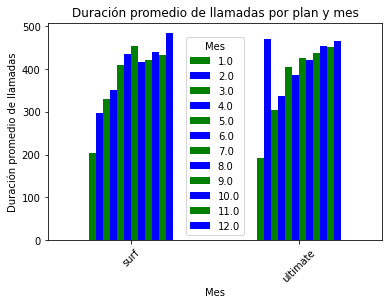

In [139]:
# Definir los colores para cada plan
colors = {'surf': 'green', 'ultimate': 'blue'}

# Calcular la duración promedio de llamadas por cada plan y por cada mes
average_call_duration = users_monthly_data.groupby(['plan_name', 'month'])['minutes_per_month'].mean()

# Crear un gráfico de barras para visualizar la duración promedio de llamadas por cada plan y por cada mes
plt.figure(figsize=(12, 8))
average_call_duration.unstack().plot(kind='bar', color=[colors[plan] for plan in average_call_duration.unstack().index])
plt.title('Duración promedio de llamadas por plan y mes')
plt.xlabel('Mes')
plt.ylabel('Duración promedio de llamadas')
plt.xticks(rotation=45)
plt.legend(title='Mes')
plt.show()



In [140]:
# Calcular la duración promedio de llamadas por cada plan y por cada mes
pivot_table = average_call_duration.unstack()

# Visualizar la tabla pivote
pivot_table


month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
plan_name,,,,,,,,,,,,
surf,203.0,297.000000,330.00,351.540000,410.240000,435.791667,453.733333,417.849057,420.732984,440.891775,432.494585,484.501608
ultimate,193.5,470.333333,304.25,336.857143,406.241379,387.444444,427.067797,421.436620,437.511628,455.028571,452.320000,465.261745


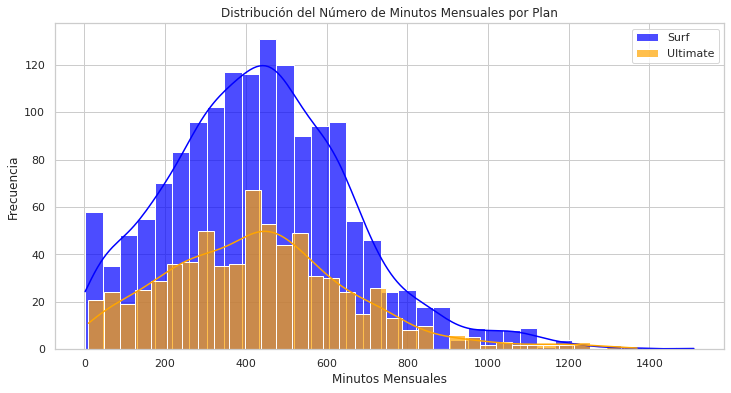

In [141]:
# Filtra los datos por plan
surf_data = users_monthly_data[users_monthly_data['plan'] == 'surf']['minutes_per_month']
ultimate_data = users_monthly_data[users_monthly_data['plan'] == 'ultimate']['minutes_per_month']

# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea un histograma para cada plan
plt.figure(figsize=(12, 6))
sns.histplot(surf_data, bins=35, kde=True, color='blue', label='Surf', alpha=0.7)
sns.histplot(ultimate_data, bins=35, kde=True, color='orange', label='Ultimate', alpha=0.7)

# Personaliza el gráfico
plt.title('Distribución del Número de Minutos Mensuales por Plan')
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.legend()

# Muestra el gráfico
plt.show()

In [142]:
# Calcula la media y la varianza de la duración mensual de llamadas.

# Agrupa los datos por plan y mes y calcula la duración mensual promedio y la varianza
call_duration_stats = users_monthly_data.groupby(['plan', 'month'])['minutes_per_month'].agg(['mean', 'var']).reset_index()

# Renombra las columnas para mayor claridad
call_duration_stats = call_duration_stats.rename(columns={'mean': 'mean_duration', 'var': 'variance_duration'})

# Muestra las estadísticas de duración de llamadas
display(call_duration_stats)


,plan,month,mean_duration,variance_duration
0,surf,1.0,203.000000,15842.000000
1,surf,2.0,297.000000,52226.500000
2,surf,3.0,330.000000,35809.363636
3,surf,4.0,351.540000,50866.743265
4,surf,5.0,410.240000,56938.779459
5,surf,6.0,435.791667,44094.061404
6,surf,7.0,453.733333,59802.012325
7,surf,8.0,417.849057,52122.749224
8,surf,9.0,420.732984,44579.912538
9,surf,10.0,440.891775,48699.905628


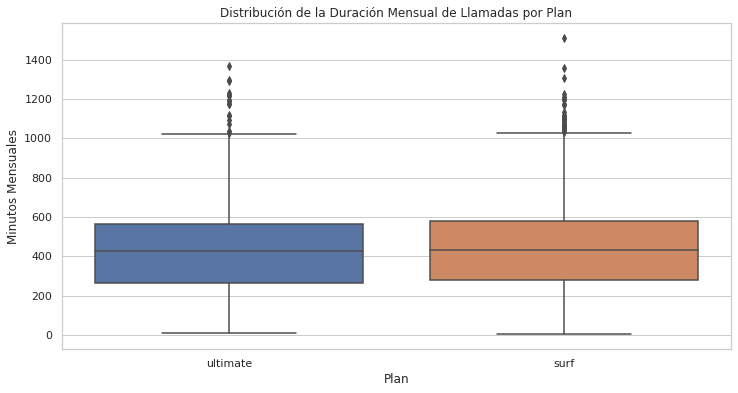

In [143]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea un diagrama de caja para la duración mensual de llamadas por cada plan
plt.figure(figsize=(12, 6))
sns.boxplot(x='plan', y='minutes_per_month', data=users_monthly_data)

# Personaliza el gráfico
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Minutos Mensuales')

# Muestra el gráfico
plt.show()

El análisis de la duración mensual de las llamadas revela diferencias significativas en el comportamiento de los usuarios entre los planes "Surf" y "Ultimate". En general, los usuarios del plan "Surf" muestran una duración promedio de llamadas más larga, pero también presentan una mayor variabilidad en sus patrones de llamadas, como se evidencia en la dispersión de la duración. Por otro lado, los usuarios del plan "Ultimate" tienden a tener una duración de llamadas más consistente y, en promedio, más corta. Esta información puede ser crucial para adaptar estrategias de marketing y servicios, teniendo en cuenta las preferencias y necesidades específicas de los usuarios en cada 

### Mensajes

In [144]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

# Agrupa los datos por plan y mes y calcula el promedio y la varianza del número de mensajes mensuales
message_stats = users_monthly_data.groupby(['plan', 'month'])['messages_per_month'].agg(['mean', 'var']).reset_index()

# Renombra las columnas para mayor claridad
message_stats = message_stats.rename(columns={'mean': 'mean_messages', 'var': 'variance_messages'})

# Muestra las estadísticas del número de mensajes por plan y mes
display(message_stats)



,plan,month,mean_messages,variance_messages
0,surf,1.0,21.000000,NaN
1,surf,2.0,21.600000,512.800000
2,surf,3.0,21.937500,352.062500
3,surf,4.0,24.166667,534.028571
4,surf,5.0,33.017857,867.945130
5,surf,6.0,33.616438,936.406393
6,surf,7.0,35.945055,907.985836
7,surf,8.0,37.596774,1013.315762
8,surf,9.0,39.523179,943.051126
9,surf,10.0,42.433862,1234.491613


In [145]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

# Agrupa los datos por plan y mes y calcula el promedio y la varianza del tráfico de Internet mensual
traffic_stats = users_monthly_data.groupby(['plan', 'month'])['gb_per_month'].agg(['mean', 'var']).reset_index()

# Renombra las columnas para mayor claridad
traffic_stats = traffic_stats.rename(columns={'mean': 'mean_traffic', 'var': 'variance_traffic'})

# Muestra las estadísticas del tráfico de Internet por plan y mes
display(traffic_stats)


,plan,month,mean_traffic,variance_traffic
0,surf,1.0,5.000000,18.000000
1,surf,2.0,12.222222,41.444444
2,surf,3.0,13.565217,63.984190
3,surf,4.0,12.469388,54.212585
4,surf,5.0,14.302632,56.267193
5,surf,6.0,15.810526,43.559462
6,surf,7.0,17.016667,59.579552
7,surf,8.0,17.201258,67.263036
8,surf,9.0,16.777202,48.038644
9,surf,10.0,17.632479,57.555335


Según las estadísticas sobre el número de mensajes y el tráfico de Internet consumido por los usuarios de cada plan, podemos observar algunas tendencias interesantes. En cuanto a los mensajes, los usuarios de ambos planes, Surf y Ultimate, muestran un aumento en el número medio de mensajes a lo largo del año, alcanzando cifras más altas hacia finales del año. Sin embargo, los usuarios del plan Ultimate tienden a tener un promedio más bajo en comparación con los usuarios del plan Surf. Respecto al tráfico de Internet, los usuarios del plan Surf y Ultimate exhiben un crecimiento constante en el consumo de datos a lo largo del año, con un pico evidente hacia finales del año. En términos generales, los usuarios del plan Ultimate parecen consumir más tráfico de Internet en comparación con los del plan Surf. En conclusión, el comportamiento de los usuarios varía en función del plan, con patrones específicos de uso de mensajes y datos para cada plan.

### Internet

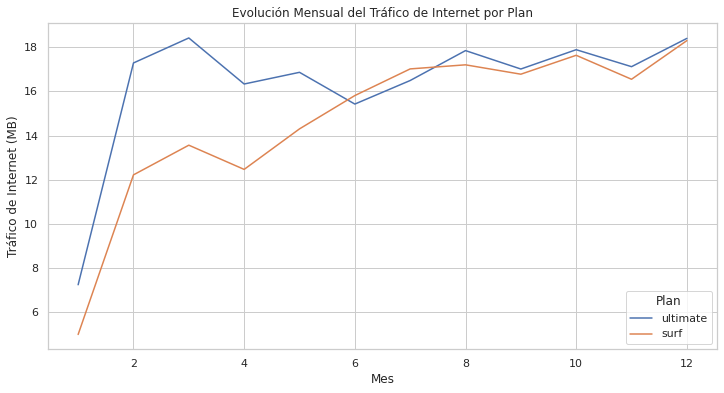

In [146]:
# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea una figura y ejes
plt.figure(figsize=(12, 6))

# Filtra los datos por plan
surf_traffic = users_monthly_data[users_monthly_data['plan'] == 'surf']['gb_per_month']
ultimate_traffic = users_monthly_data[users_monthly_data['plan'] == 'ultimate']['gb_per_month']

# Gráfico de línea para la evolución mensual del tráfico de Internet por cada plan
sns.lineplot(x='month', y='gb_per_month', data=users_monthly_data, hue='plan', ci=None)

# Personaliza el gráfico
plt.title('Evolución Mensual del Tráfico de Internet por Plan')
plt.xlabel('Mes')
plt.ylabel('Tráfico de Internet (MB)')
plt.legend(title='Plan')
plt.show()

Al analizar la evolución mensual del tráfico de Internet para los planes Surf y Ultimate, se observa que ambos planes experimentan un aumento en el consumo de datos a lo largo del tiempo. Sin embargo, el plan Surf presenta fluctuaciones más pronunciadas, con picos notables en algunos meses, sugiriendo una variabilidad mayor en el comportamiento de consumo de datos. Por el contrario, el plan Ultimate muestra una tendencia más estable, con variaciones menos marcadas a lo largo de los meses. Esta diferencia podría indicar que los usuarios del plan Surf tienden a tener un comportamiento más variable en su consumo de datos, posiblemente debido a una mayor sensibilidad a las tarifas adicionales por exceso de datos. En contraste, los usuarios del plan Ultimate parecen mantener un consumo más constante.

## Ingreso

In [147]:
# Analisis de valores atípicos en los ingresos
users_filtered = users_monthly_data.query('1 < gb_per_month < 34.5 & minutes_per_month < 1036 & messages_per_month < 141.5')
surf_data = users_filtered.query('plan == "surf"')
surf_data.info()
print()
ultimate_data = users_filtered.query('plan == "ultimate"')
ultimate_data.info()
print()
print('Ingreso promedio mensual plan Surf:', surf_data['monthly_income'].mean())
print('Ingreso promedio mensual plan Ultimate:', ultimate_data['monthly_income'].mean())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 1 to 1825
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                1104 non-null   int64         
 1   month                  1104 non-null   float64       
 2   messages_per_month     1104 non-null   float64       
 3   calls_per_month        1104 non-null   float64       
 4   minutes_per_month      1104 non-null   float64       
 5   gb_per_month           1104 non-null   float64       
 6   first_name             1104 non-null   object        
 7   last_name              1104 non-null   object        
 8   age                    1104 non-null   int64         
 9   city                   1104 non-null   object        
 10  reg_date               1104 non-null   datetime64[ns]
 11  plan                   1104 non-null   object        
 12  churn_date             1104 non-null   datetime64[ns]
 13  chu

In [148]:
print('Varianza ingreso mensual plan Surf:', np.var(surf_data['monthly_income']))
print('Varianza ingreso mensual plan Ultimate:', np.var(ultimate_data['monthly_income']))

Varianza ingreso mensual plan Surf: 1743.22042710565
Varianza ingreso mensual plan Ultimate: 7.758016179542561


Los datos revelan que, en promedio, el plan "Ultimate" generan ingresos mensuales más altos que el plan "Surf", con aproximadamente $70.42 frente a $55.02 del plan "Surf". Sin embargo, la varianza en los ingresos mensuales es mucho mayor para el plan "Surf" en comparación con el plan "Ultimate", sugiriendo una mayor variabilidad en los ingresos mensuales, lo cual indica diferentes comportamientos de consumo de los usuarios o preferencias de uso de servicios entre los dos planes. 

## Prueba las hipótesis estadísticas

In [149]:
sample_1 = surf_data['monthly_income']
sample_2 = ultimate_data['monthly_income']
alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('pvalue:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Hay evidencia suficiente para decir que los ingresos promedio son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para decir que los ingresos promedio son diferentes.") 

pvalue: 3.285180803125246e-32
Rechazamos la hipótesis nula: Hay evidencia suficiente para decir que los ingresos promedio son diferentes.


In [150]:
unique_cities = users_df['city'].unique()
print("Ciudades en el conjunto de datos:")
print(unique_cities)

Ciudades en el conjunto de datos:
['Atlanta-Sandy Springs-Roswell, GA MSA' 'Seattle-Tacoma-Bellevue, WA MSA'
 'Las Vegas-Henderson-Paradise, NV MSA' 'Tulsa, OK MSA'
 'Dallas-Fort Worth-Arlington, TX MSA'
 'San Francisco-Oakland-Berkeley, CA MSA' 'Grand Rapids-Kentwood, MI MSA'
 'Orlando-Kissimmee-Sanford, FL MSA'
 'San Jose-Sunnyvale-Santa Clara, CA MSA' 'Cleveland-Elyria, OH MSA'
 'Chicago-Naperville-Elgin, IL-IN-WI MSA' 'Knoxville, TN MSA'
 'New York-Newark-Jersey City, NY-NJ-PA MSA' 'Pittsburgh, PA MSA'
 'Fresno, CA MSA' 'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA'
 'Indianapolis-Carmel-Anderson, IN MSA' 'Jacksonville, FL MSA'
 'Los Angeles-Long Beach-Anaheim, CA MSA'
 'Omaha-Council Bluffs, NE-IA MSA'
 'Houston-The Woodlands-Sugar Land, TX MSA'
 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA'
 'Tampa-St. Petersburg-Clearwater, FL MSA' 'Birmingham-Hoover, AL MSA'
 'Oklahoma City, OK MSA' 'Charlotte-Concord-Gastonia, NC-SC MSA'
 'Denver-Aurora-Lakewood, CO MSA'
 'Nashville-Da

In [151]:
def region_id(city):
    
    if 'NY-NJ' in city or 'NY' in city or 'NJ' in city:
        return 'ny-nj'
    return 'other'

In [152]:
users_monthly_data['region'] = users_monthly_data['city'].apply(region_id)

In [153]:
users_monthly_data['region'].value_counts(dropna=False)

other    1814
ny-nj     489
Name: region, dtype: int64

In [154]:
ny_nj_users = users_monthly_data.query('region == "ny-nj"')
other_region_users = users_monthly_data.query('region == "other"')


In [155]:
print('Ingreso promedio mensual región NY-NJ:', ny_nj_users['monthly_income'].mean())
print('Ingreso promedio mensual otras regiones:', other_region_users['monthly_income'].mean())
print()
print('Varianza ingreso mensual región NY-NJ:', np.var(ny_nj_users['monthly_income']))
print('Varianza ingreso mensual otras regiones:', np.var(other_region_users['monthly_income']))


Ingreso promedio mensual región NY-NJ: 61.37701431492842
Ingreso promedio mensual otras regiones: 65.01864388092613

Varianza ingreso mensual región NY-NJ: 2101.7204041736195
Varianza ingreso mensual otras regiones: 2183.9032367496957


In [156]:
sample_1 = ny_nj_users['monthly_income']
sample_2 = other_region_users['monthly_income']
alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('pvalue:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Hay evidencia suficiente para decir que los ingresos promedio son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para decir que los ingresos promedio son diferentes.") 

pvalue: 0.12126002617160818
No podemos rechazar la hipótesis nula: No hay evidencia suficiente para decir que los ingresos promedio son diferentes.


1. Conclusiones del Procesamiento de Datos

Durante este análisis, se abordaron cinco conjuntos de datos distintos:

En el conjunto de datos users, se identificaron errores en el formato de las fechas, que se corrigieron exitosamente transformándolas al tipo de dato datetime. Además, se detectaron valores faltantes en la columna que registra la fecha de inactivación de las cuentas, para resolver esto se optó por crear una nueva columna que clasifica a los clientes como activos o inactivos, llenando los valores faltantes con una fecha ficticia fuera del período de estudio.
En el conjunto de datos calls, se encontraron fechas con un formato incorrecto, las cuales se convirtieron adecuadamente a tipo datetime. Asimismo, se redondearon los valores de duración de las llamadas, ya que Megaline utiliza valores redondeados para fines de facturación.
En el conjunto de datos messages, se identificó el mismo problema con las fechas de los mensajes, las cuales también fueron transformadas al formato datetime.
En el conjunto de datos internet, se modificaron las fechas al tipo datetime y se realizó la conversión de MB a GB. Posteriormente, se redondearon hacia arriba los valores de GB utilizados, siguiendo las prácticas de redondeo establecidas por Megaline.
En el conjunto de datos plans, solo fue necesario realizar la conversión de MB a GB para los límites de consumo de datos de los planes Surf y Ultimate.

2. Conclusiones sobre el Enriquecimiento de Datos

Se logró obtener información detallada sobre el número de llamadas, minutos, mensajes y volumen de datos mensuales para cada usuario mediante el uso de tablas dinámicas que agruparon a los usuarios por mes. Estos valores se integraron en una nueva tabla mediante la operación de merge, fusionándolos con los datos del conjunto users.
Durante el proceso de fusión, se generaron valores faltantes que correspondían a usuarios que no habían realizado ninguna llamada, enviado mensajes o utilizado datos. Estos valores faltantes fueron interpretados como indicadores de no consumo y se rellenaron con ceros. Además, se eliminaron los usuarios inactivos que no registraron ningún consumo de datos, mensajes o llamadas, ya que no contribuyen a los ingresos de la empresa.
Para calcular los ingresos mensuales de cada usuario, se desarrolló una función que, según el tipo de plan del cliente, calculaba la diferencia en minutos, mensajes y datos utilizados, multiplicándola por la tarifa correspondiente. Este resultado se sumó al cargo mensual fijo por el plan.
Se creó una nueva columna para identificar a los clientes ubicados en Nueva York-Nueva Jersey, con el fin de distinguirlos de los clientes de otras regiones.

3. Análisis Estadístico y Pruebas de Hipótesis:
   De las dos hipótesis planteadas, se puede concluir lo siguiente:

Los usuarios del Plan Ultimate generan ingresos mensuales promedio más altos para la empresa Megaline en comparación con los usuarios del Plan Surf. Esta conclusión se basa en la prueba de igualdad de medias poblacionales T-student para varianzas no homogéneas, confirmando la hipótesis inicial de que hay diferencias en los ingresos entre los planes prepago de la empresa.

No se encontraron diferencias significativas en los ingresos mensuales promedio entre los residentes de la región de Nueva York-Nueva Jersey y otras regiones del país. Esta conclusión se basa en una prueba T-student para varianzas no homogéneas, lo que refuta la hipótesis de que los ingresos difieren entre los clientes de NY-NJ y otras regiones.

Se observó una alta varianza en los ingresos mensuales para el plan Surf, mientras que la varianza para los clientes del plan Ultimate fue más baja. Esto sugiere que hay más usuarios del plan Surf que exceden los límites de la tarifa en consumo de mensajes, llamadas y datos, en comparación con los clientes del plan Ultimate. A pesar de que los usuarios del plan Ultimate no exceden los límites de la tarifa, este plan sigue generando más ingresos para la empresa Megaline.


Teniendo en cuenta estos hallazgos, se recomienda que Megaline dirija su presupuesto publicitario hacia el plan Ultimate o explore la posibilidad de migrar a los clientes de Surf hacia el plan Ultimate. Esto se debe a que varios usuarios de Surf han registrado un consumo por encima del límite mensual del plan, lo que podría resultar más conveniente tanto para los clientes como para la empresa cambiarse a un plan más costoso pero con límites de consumo más amplios.